In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF, PCA
from sklearn.linear_model import Ridge, LogisticRegression, Lasso
from sklearn.metrics import mean_squared_error as mse, roc_auc_score as roc, accuracy_score as acc, log_loss
from sklearn.neural_network import MLPClassifier, MLPRegressor
import numpy as np
import pandas as pd
from data.dataset import BaseDataset
from scipy.sparse import csr_matrix
from importlib import reload
import itertools as it
import seaborn as sns

dataset = 'peerread_small'


In [3]:
def get_normalized_pmi(topics, counts, num_words=20):
    num_topics = topics.shape[0]
    per_topic_npmi = np.zeros(num_topics)
    tf = csr_matrix(counts)
    cooccurence = tf.T.dot(tf)
    cooccurence = cooccurence.toarray()
    
    count = counts.sum(axis=0)
    prob = count/count.sum()
    cooccurence_prob = cooccurence/cooccurence.sum()

    for k in range(num_topics):
        npmi_total = 0
        beta = topics[k,:]
        top_words = (-beta).argsort()[:num_words]
        n = 0 
        for (w1, w2) in it.combinations(top_words, 2):
            log_joint_prob = np.log(cooccurence_prob[w1][w2]+1e-6)
            log_prob_w1 = np.log(prob[w1]+1e-6)
            log_prob_w2 = np.log(prob[w2]+1e-6)
            pmi = log_joint_prob - (log_prob_w1+log_prob_w2)
            normalizer = -log_joint_prob
            npmi_total += pmi/normalizer
            n+=1
        per_topic_npmi[k] = npmi_total / n
    return per_topic_npmi.mean()

## Processing data 

In [4]:
if dataset == 'amazon':
    datafile = '../../dat/reviews_Office_Products_5.json'
elif dataset == 'yelp':
    datafile = '../../dat/yelp_review_polarity_csv/train.csv'
elif dataset == 'peerread' or dataset == 'peerread_small':
    datafile = '../../dat/peerread_abstracts.csv'
else:
    datafile = '../../dat/cs_papers.gz'


proc_file = '../../dat/proc/' + dataset + '_proc.npz'
components = {'amazon':30, 'semantic_scholar':50, 'peerread':40, 'peerread_small':20, 'yelp':30}
text_dataset = BaseDataset(dataset, datafile, proc_file, use_bigrams=False)

counts = text_dataset.data
vocab= text_dataset.metadata

n_components=components[dataset]
num_documents = counts.shape[0]
n_components, num_documents, counts.shape[1]

(20, 11777, 500)

In [17]:
n_folds=1
split=0
text_dataset.assign_splits(num_splits=n_folds)
text_dataset.split_data(0)
counts = text_dataset.tr_data
counts.shape

(11777, 500)

In [18]:
lda_model = LDA(n_components=n_components)
doc_rep = lda_model.fit_transform(counts)
print("Perplexity:", lda_model.perplexity(counts))
print("Log likelihood:", lda_model.score(counts))

Perplexity: 309.61355327961445
Log likelihood: -3167143.919967285


<AxesSubplot:>

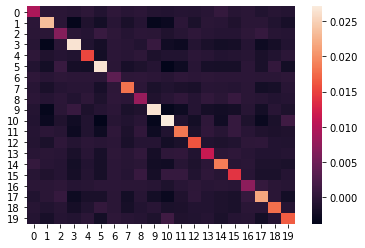

In [22]:
C = np.cov(doc_rep.T)
sns.heatmap(C)

In [23]:
z = lda_model.transform(text_dataset.te_data)
beta = lda_model.components_ / lda_model.components_.sum(axis=1)[:,np.newaxis]
prob = z.dot(beta)
nll = -(np.log(prob + 1e-6) * text_dataset.te_data).sum(axis=1).mean()
print("NLL:", nll)

ValueError: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [24]:
unnormalized_topics = lda_model.components_
topics = lda_model.components_ / lda_model.components_.sum(axis=1)[:,np.newaxis]
print("NPMI:", get_normalized_pmi(topics, counts))

for k in range(n_components):
    beta = topics[k]
    top_words = (-beta).argsort()[:7]
    topic_words = [(vocab[t], round(beta[t],2)) for t in top_words]
    print('Topic {}: {}'.format(k, topic_words))

NPMI: 0.027813702934811523
Topic 0: [('user', 0.07), ('feature', 0.07), ('task', 0.04), ('online', 0.02), ('item', 0.02), ('group', 0.02), ('method', 0.02)]
Topic 1: [('system', 0.07), ('event', 0.02), ('process', 0.02), ('paper', 0.02), ('information', 0.02), ('ontology', 0.02), ('application', 0.02)]
Topic 2: [('graph', 0.11), ('constraint', 0.08), ('program', 0.06), ('programming', 0.04), ('set', 0.04), ('problem', 0.03), ('solver', 0.03)]
Topic 3: [('method', 0.04), ('function', 0.04), ('algorithm', 0.03), ('problem', 0.03), ('matrix', 0.02), ('data', 0.02), ('learning', 0.02)]
Topic 4: [('model', 0.09), ('learning', 0.09), ('data', 0.07), ('machine', 0.04), ('topic', 0.02), ('approach', 0.02), ('latent', 0.01)]
Topic 5: [('problem', 0.07), ('algorithm', 0.05), ('solution', 0.03), ('search', 0.02), ('optimal', 0.02), ('time', 0.02), ('approach', 0.01)]
Topic 6: [('domain', 0.11), ('target', 0.06), ('metric', 0.06), ('search', 0.06), ('distance', 0.03), ('source', 0.03), ('data', 0.

In [25]:
pretrained_out_file = '../../dat/proc/' + dataset+ '_pretraining'
np.savez_compressed(pretrained_out_file, theta=doc_rep, beta=topics)
doc_rep.shape, topics.shape

((11777, 20), (20, 500))

In [15]:
K=20
pca = PCA(n_components=K)
x = csr_matrix(counts)
cov = x.T.dot(x)
cov = cov.toarray()
pca.fit(cov)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [16]:
loadings = pca.components_
loadings.shape
for k in range(K):
    beta = loadings[k]
    top_words = (-beta).argsort()[:7]
    topic_words = [(vocab[t], round(beta[t],2)) for t in top_words]
    print('Topic {}: {}'.format(k, topic_words))

Topic 0: [('model', 0.39), ('learning', 0.26), ('algorithm', 0.23), ('data', 0.23), ('method', 0.22), ('network', 0.21), ('problem', 0.19)]
Topic 1: [('model', 0.62), ('network', 0.18), ('neural', 0.15), ('language', 0.12), ('word', 0.11), ('task', 0.07), ('representation', 0.07)]
Topic 2: [('network', 0.68), ('neural', 0.26), ('deep', 0.2), ('learning', 0.2), ('method', 0.1), ('convolutional', 0.09), ('training', 0.09)]
Topic 3: [('data', 0.45), ('method', 0.26), ('system', 0.2), ('feature', 0.17), ('approach', 0.15), ('language', 0.14), ('word', 0.12)]
Topic 4: [('learning', 0.56), ('data', 0.4), ('model', 0.22), ('deep', 0.08), ('training', 0.06), ('machine', 0.06), ('learn', 0.04)]
Topic 5: [('data', 0.62), ('network', 0.24), ('algorithm', 0.17), ('set', 0.08), ('clustering', 0.06), ('model', 0.06), ('time', 0.05)]
Topic 6: [('method', 0.72), ('feature', 0.11), ('model', 0.09), ('problem', 0.09), ('proposed', 0.07), ('word', 0.05), ('matrix', 0.05)]
Topic 7: [('algorithm', 0.49), (

In [22]:
factors = pca.transform(cov)
C = np.cov(factors.T)

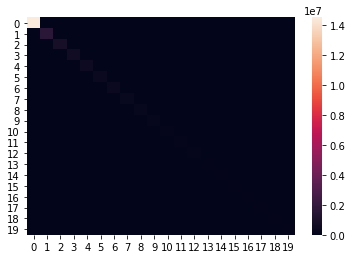

In [23]:
sns.heatmap(C)